# Predicting Acceptance of US Visa Applications Using Machine Learning
Capstone Project for SlideRule Intensive Data Science workshop.

Charles Franzen

## The Project

Each year hundreds of thousands of applications are filed for work visas in the US. So many, in fact, that legistated caps on the number of H-1B applications have been reached every single year since 2007. In 2008, the quota was reached on the first day of open applications. In light of this, companies and potential employees that are lucky enough to get their application in via the lottery want to ensure that they have as high a chance as possible of having their application approved.

My project is to investigate application data sets and create models that will predict the acceptance or rejection of a given application. This model could evaluate the strength of an application before it is submitted, and provide insights into how a weak application could be improved. The model will also elucidate the most important factors determining the fate of a visa application.

## The Data

I will be investigating data published by the US Dapartment of Labor. The data sets are comprised of quarterly application data and decisions for different types of visas. I will be focusing on two of these data sets: one that includes a mix of all visa types, and one that is comprised solely of H-1B visas.

The data fields cover a wide range of information, including details about the country of origin of the applicant, location and type of the job, pay and educational requirements of the job, education of the applicant, and whether all regulatory hurdles have been cleared.

H-1B visas are work visas that are only for 'specialty applications', and therefore can act as a bellweather for how much highly-educated talent the US is importing.

## Methodology

I will be treating this as a classification problem. The binary variable 'denied' will indicate whether an application was rejected.

So far I have used logistic regression and decision tree classification to model the all-visa dataset. Next steps include refining the models, investigating similar models for the H-1B subset, and continuing with other machine learning techniques, including SVM.

### Logistic Regression

In order to implement logistic regression, I've had to format the data sets, converting string cell values into integers or floats, and creating dummy variables for categorical data.

Scikit Learn does not provide a method for adjusting the threshold probability for classification, so this had to be adjusted manually.

Using backdata from the Department of Labor, I will test my models and further refine them.

### Decision Tree Classification

Once the data is formatted for Logistic Regression, it is easy to fit it to a decision tree. Again, I would like to adjust the threshold at which test cases are marked as weak, but I haven't yet figured out how to do that.

## Limitations

Since the base rate of application rejection is so low (6.7% for all visa types), it may be difficult to suss out relevant variables. Thus far my models have tended to have a high number of false-negatives (type II errors).

The models may also end up provinding unhelpful insights. For example, the model may identify country of citizenship as a crucial determiner. It won't be helpful to most applicants to tell them to change their citizenship.

## Import Modules

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split,  cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

In [2]:
# setting matplotlib style
plt.style.use('fivethirtyeight')

# All Visas

## Data Loading and Initial Processing
Withdrawn applications are removed from the data set, since there was no decision made.

In [3]:
# loading data
data = pd.read_excel('Data/PERM_Disclosure_Data_FY15_Q4.xlsx', 'DDFY2015_Final')

# removing withdrawn applications
data = data[data['CASE_STATUS'] != 'Withdrawn']

# adding a binary series with 1 indicating that an application was denied
data['denied'] = (data.CASE_STATUS == 'Denied').astype(int)

## Descriptive Statistics

To do:

1. make pie charts for country of origin, education, case status, visa type
2. make histograms for salary/wage, training, and experience requirements

In [4]:
status = data['CASE_STATUS'].value_counts()
status

Certified            40176
Certified-Expired    38762
Denied                5696
Name: CASE_STATUS, dtype: int64

In [5]:
pcert, pcertex, pdenied = (data['CASE_STATUS'].value_counts().values) / float(len(data))
size = len(data)
print 'Certified: \t\t', pcert, '\nCertified-Expired: \t', pcertex, '\nDenied: \t\t', pdenied, '\nSize: \t\t\t', size
                                                                 

Certified: 		0.474702838103 
Certified-Expired: 	0.457995604603 
Denied: 		0.0673015572938 
Size: 			84634


([<matplotlib.patches.Wedge at 0x10aa03150>,
  <matplotlib.text.Text at 0x10ae65290>])

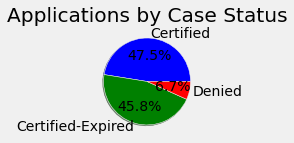

In [28]:
labels = list(status.index)
fracs = pcert, pcertex, pdenied
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Case Status')
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

Base rate of denials is low, at 6.7%, and many accepted applications are allowed to expire.

In [29]:
serror = (pdenied*(1-pdenied)/float(len(data))) ** .5
print 'Standard Error: ',serror

Standard Error:  0.000861213341343


### Categorical Data

In [30]:
# possibly interesting columns of categorical data
dfcat = data[['denied', 'EMPLOYER_NAME', 'EMPLOYER_STATE', 'AGENT_FIRM_NAME', 'PW_SOC_TITLE', 'JOB_INFO_EDUCATION', 
              'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION', 
              'FOREIGN_WORKER_INFO_MAJOR']]

After exploring the columns, Visa Type, Country of Citizenship, and Education seem to be the most interesting columns.

In [31]:
# visa types with a high rate of denial
dftype = dfcat[['CLASS_OF_ADMISSION', 'denied']]
dftype1 = dftype.groupby('CLASS_OF_ADMISSION').mean()
dftype1['size'] = dftype.groupby('CLASS_OF_ADMISSION').agg(sum)
dftype = dftype1[(dftype1['denied'] > (pdenied + 2*serror)) & (dftype1['size'] >= 10)]
dftype.head()

,denied,size
CLASS_OF_ADMISSION,,
B-1,0.347826,40
B-2,0.265248,187
E-1,0.149123,17
E-2,0.123584,120
E-3,0.071429,11


In [32]:
visa_types = dfcat.groupby('CLASS_OF_ADMISSION').count()['denied']
visa_types = visa_types.sort_values()[:-5:-1]
visa_types

CLASS_OF_ADMISSION
H-1B          64729
L-1            5136
F-1            3163
Not in USA     1554
Name: denied, dtype: int64

In [33]:
# countries with a high rate of denial
dfcit = dfcat[['COUNTRY_OF_CITIZENSHIP', 'denied']]
dfcit1 = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').mean()
dfcit1['size'] = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').agg(sum)
dfcit = dfcit1[(dfcit1['denied'] > (pdenied + 2*serror)) & (dfcit1['size'] >= 10)]
dfcit.sort_values('denied')[::-1].head()

,denied,size
COUNTRY_OF_CITIZENSHIP,,
GAMBIA,0.850000,17
SLOVAKIA,0.400000,12
GUATEMALA,0.303371,27
ECUADOR,0.270408,53
EL SALVADOR,0.237624,24


In [34]:
countries = dfcat.groupby('COUNTRY_OF_CITIZENSHIP').count()['denied']
countries = countries.sort_values()[::-1][:5]
countries['ALL_OTHERS'] = 19427
countries

COUNTRY_OF_CITIZENSHIP
INDIA          47705
CHINA           6843
SOUTH KOREA     5645
CANADA          3139
PHILIPPINES     1875
ALL_OTHERS     19427
Name: denied, dtype: int64

([<matplotlib.patches.Wedge at 0x10b33aa90>,
  <matplotlib.text.Text at 0x10b4cce50>])

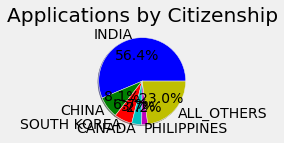

In [35]:
country_labels = list(countries.index)
country_fracs = countries.values
plt.subplot(the_grid[1, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

In [36]:
dfcat.groupby(['FOREIGN_WORKER_INFO_EDUCATION'])['denied'].mean().sort_values()

FOREIGN_WORKER_INFO_EDUCATION
Doctorate      0.033010
Master's       0.051275
Bachelor's     0.053348
Other          0.074332
Associate's    0.185270
None           0.228803
High School    0.270021
Name: denied, dtype: float64

In [37]:
education = dfcat.groupby('FOREIGN_WORKER_INFO_EDUCATION').count()['denied'].sort_values()[::-1]
education

FOREIGN_WORKER_INFO_EDUCATION
Master's       38245
Bachelor's     30910
None            4812
Doctorate       4635
Other           3740
High School     1411
Associate's      869
Name: denied, dtype: int64

([<matplotlib.patches.Wedge at 0x10ccb6d10>,
  <matplotlib.text.Text at 0x10ca93b10>])

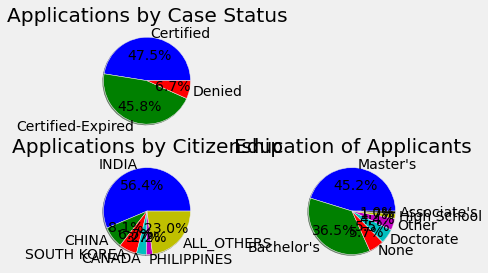

In [38]:
status_labels = list(status.index)
status_fracs = pcert, pcertex, pdenied
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Case Status')
plt.pie(status_fracs, labels=status_labels, autopct='%1.1f%%', shadow=True)

country_labels = list(countries.index)
country_fracs = countries.values
plt.subplot(the_grid[1, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

ed_labels = list(education.index)
ed_fracs = education.values
plt.subplot(the_grid[1, 1], aspect=1, title='Education of Applicants')
plt.pie(ed_fracs, labels=ed_labels, autopct='%1.1f%%', shadow=True)

In [39]:
dfcat.groupby(['JOB_INFO_EDUCATION'])['denied'].mean().sort_values()

JOB_INFO_EDUCATION
Doctorate      0.025573
Master's       0.047168
Bachelor's     0.051324
Other          0.075218
Associate's    0.188406
None           0.233772
High School    0.304193
Name: denied, dtype: float64

Applicants with at least a Bachelor's have significantly lower rates of rejection than those without one.

## Data Preparation for Logistic Regression

All of the data are given as unicode, even the numbers, so it has to be converted into the proper data type before the regression can be run. Additionally, dummy variables need to be created for the categorical data.

In [40]:
# interesting fields with binary or numerical data
data_fields = ['REFILE', 'EMPLOYER_NUM_EMPLOYEES', 
               'FOREIGN_WORKER_OWNERSHIP_INTEREST', 'PW_AMOUNT_9089', 'WAGE_OFFER_FROM_9089', 'WAGE_OFFER_TO_9089', 
               'JOB_INFO_TRAINING', 'JOB_INFO_TRAINING_NUM_MONTHS', 'JOB_INFO_EXPERIENCE', 
               'JOB_INFO_EXPERIENCE_NUM_MONTHS', 'JOB_INFO_ALT_FIELD', 'JOB_INFO_ALT_COMBO_ED_EXP', 
               'JOB_INFO_ALT_CMB_ED_OTH_YRS', 'JOB_INFO_FOREIGN_ED', 'JOB_INFO_ALT_OCC', 'JOB_INFO_ALT_OCC_NUM_MONTHS', 
               'JOB_INFO_JOB_REQ_NORMAL', 'JOB_INFO_FOREIGN_LANG_REQ', 'JOB_INFO_COMBO_OCCUPATION',
               'JI_FOREIGN_WORKER_LIVE_ON_PREMISES', 'JI_LIVE_IN_DOMESTIC_SERVICE', 'JI_LIVE_IN_DOM_SVC_CONTRACT', 
               'RECR_INFO_PROFESSIONAL_OCC', 'RECR_INFO_COLL_UNIV_TEACHER', 'RECR_INFO_COLL_TEACH_COMP_PROC', 
               'RI_POSTED_NOTICE_AT_WORKSITE', 'RI_LAYOFF_IN_PAST_SIX_MONTHS', 'RI_US_WORKERS_CONSIDERED', 
               'FOREIGN_WORKER_INFO_TRAINING_COMP', 'FOREIGN_WORKER_INFO_REQ_EXPERIENCE', 
               'FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE', 'FOREIGN_WORKER_INFO_REL_OCCUP_EXP', 
               'PREPARER_INFO_EMP_COMPLETED']
dflogit = data[data_fields]

In [41]:
dflogit.head()

,REFILE,EMPLOYER_NUM_EMPLOYEES,FOREIGN_WORKER_OWNERSHIP_INTEREST,PW_AMOUNT_9089,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,JOB_INFO_TRAINING,JOB_INFO_TRAINING_NUM_MONTHS,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,...,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_TRAINING_COMP,FOREIGN_WORKER_INFO_REQ_EXPERIENCE,FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE,FOREIGN_WORKER_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED
0,N,1935,N,"83,366.00","90,000.00","95,000.00",N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,Y,N
1,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
2,N,4,N,"49,982.00","65,000.00",NaN,N,NaN,Y,36,...,N,NaN,Y,N,NaN,A,Y,A,A,N
3,N,8,N,"43,514.00","43,514.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
4,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N


In [42]:
def remove_commas(uni):
    # converts unicode numbers with commas into floats
    string = str(uni)
    if ',' in string:
        return float(string.replace(',', ''))
    elif '#' in string:
        return 0

def data_clean(df):
    # formats datatypes to binary for indicators or floats for numbers
    columns = df.columns
    dfr = pd.DataFrame()
    for column in columns:
        name = str(column)
        name = name.lower()
        if str(df[column][1]) in ['Y', 'N']:
            dfr[name] = (df[column] == 'Y').astype(int)
        else:
            try:
                dfr[name] = df[column].apply(str).apply(remove_commas)
            except ValueError:
                continue
    return dfr

def add_columns(df1, df2, columns):
    # adds columns from one dataframe to another
    for column in columns:
        df2[column] = df1[column]

In [43]:
dflogit = data_clean(dflogit)

In [44]:
# adding prevailing wage comparison features
dflogit['lowball'] = (dflogit['pw_amount_9089'] > dflogit['wage_offer_from_9089']).apply(int)
dflogit['highoffer'] = (dflogit['pw_amount_9089'] < dflogit['wage_offer_to_9089']).apply(int)

I thought that perhaps the how the wage offered to the immigrant worker compared to the prevailing wage of the profession might affect rejection, so I added two feature to identify lowball and higher-than-normal offers.

In [45]:
# formatting data for logistic regression

new_columns = ['JOB_INFO_EDUCATION', 'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION',
               'denied']
add_columns(data, dflogit, new_columns)

In [46]:
dflogit = dflogit.fillna(0)

In [47]:
dflogit.head()

,refile,employer_num_employees,foreign_worker_ownership_interest,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089,job_info_training,job_info_training_num_months,job_info_experience,job_info_experience_num_months,...,foreign_worker_info_alt_edu_experience,foreign_worker_info_rel_occup_exp,preparer_info_emp_completed,lowball,highoffer,JOB_INFO_EDUCATION,COUNTRY_OF_CITIZENSHIP,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,denied
0,0,0,0,83366,90000,95000,0,0,0,0,...,0,0,0,0,1,Bachelor's,INDIA,H-1B,Bachelor's,0
1,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,0,None,SOUTH KOREA,0,None,1
2,0,0,0,49982,65000,0,0,0,1,0,...,0,0,0,0,0,Doctorate,GERMANY,H-1B,Doctorate,1
3,0,0,0,43514,43514,0,0,0,0,0,...,0,0,0,0,0,Master's,SOUTH KOREA,E-2,Master's,0
4,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,0,None,SOUTH KOREA,0,None,1


In [48]:
# checking data types
dflogit.dtypes

refile                                      int64
employer_num_employees                      int64
foreign_worker_ownership_interest           int64
pw_amount_9089                            float64
wage_offer_from_9089                      float64
wage_offer_to_9089                        float64
job_info_training                           int64
job_info_training_num_months                int64
job_info_experience                         int64
job_info_experience_num_months              int64
job_info_alt_field                          int64
job_info_alt_combo_ed_exp                   int64
job_info_alt_cmb_ed_oth_yrs                 int64
job_info_foreign_ed                         int64
job_info_alt_occ                            int64
job_info_alt_occ_num_months                 int64
job_info_job_req_normal                     int64
job_info_foreign_lang_req                   int64
job_info_combo_occupation                   int64
ji_foreign_worker_live_on_premises          int64


In [49]:
len(dflogit)

84634

In [50]:
wages = dflogit[['pw_amount_9089', 'wage_offer_from_9089', 'wage_offer_to_9089']].replace('0', np.nan)
wages.describe()

,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089
count,82951.000000,82247.000000,22451.000000
mean,85402.096103,93688.169319,127946.312091
std,38569.882008,39830.833135,44435.788980
min,1067.200000,1060.000000,1000.000000
25%,67808.000000,72467.000000,102200.000000
50%,84802.000000,90459.000000,127300.000000
75%,103938.000000,110410.000000,148400.000000
max,5067600.000000,1145000.000000,1347000.000000


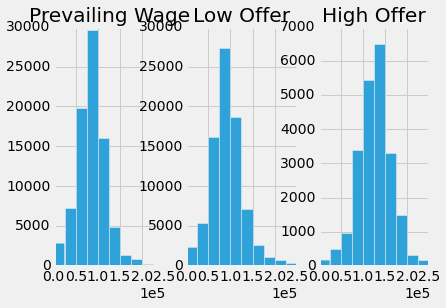

In [51]:
# histograms of wage data
fig, ax = plt.subplots(ncols=3)
index = 0
titles = ['Prevailing Wage', 'Low Offer', 'High Offer']
for column in wages.columns:
    column = str(column)
    ax[index].hist(wages[column].values, range=(0, 250000))
    ax[index].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[index].set_title(titles[index])
    index += 1

In [52]:
params = dflogit.columns[:-5]
dummies = ['C(JOB_INFO_EDUCATION)', 'C(COUNTRY_OF_CITIZENSHIP)', 'C(CLASS_OF_ADMISSION)', 'C(FOREIGN_WORKER_INFO_EDUCATION)']
f = 'denied ~ ' + ' + '.join(params) + ' + ' + ' + '.join(dummies)
f

'denied ~ refile + employer_num_employees + foreign_worker_ownership_interest + pw_amount_9089 + wage_offer_from_9089 + wage_offer_to_9089 + job_info_training + job_info_training_num_months + job_info_experience + job_info_experience_num_months + job_info_alt_field + job_info_alt_combo_ed_exp + job_info_alt_cmb_ed_oth_yrs + job_info_foreign_ed + job_info_alt_occ + job_info_alt_occ_num_months + job_info_job_req_normal + job_info_foreign_lang_req + job_info_combo_occupation + ji_foreign_worker_live_on_premises + ji_live_in_domestic_service + ji_live_in_dom_svc_contract + recr_info_professional_occ + recr_info_coll_univ_teacher + recr_info_coll_teach_comp_proc + ri_posted_notice_at_worksite + ri_layoff_in_past_six_months + ri_us_workers_considered + foreign_worker_info_training_comp + foreign_worker_info_req_experience + foreign_worker_info_alt_edu_experience + foreign_worker_info_rel_occup_exp + preparer_info_emp_completed + lowball + highoffer + C(JOB_INFO_EDUCATION) + C(COUNTRY_OF_CITI

In [53]:
# prep dataframes for sklearn logit
y, X = dmatrices(f, dflogit, NA_action='raise', return_type="dataframe")
print X.columns

Index([u'Intercept', u'C(JOB_INFO_EDUCATION)[T.Associate's]',
       u'C(JOB_INFO_EDUCATION)[T.Bachelor's]',
       u'C(JOB_INFO_EDUCATION)[T.Doctorate]',
       u'C(JOB_INFO_EDUCATION)[T.High School]',
       u'C(JOB_INFO_EDUCATION)[T.Master's]', u'C(JOB_INFO_EDUCATION)[T.None]',
       u'C(JOB_INFO_EDUCATION)[T.Other]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.AFGHANISTAN]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.ALBANIA]',
       ...
       u'ri_posted_notice_at_worksite', u'ri_layoff_in_past_six_months',
       u'ri_us_workers_considered', u'foreign_worker_info_training_comp',
       u'foreign_worker_info_req_experience',
       u'foreign_worker_info_alt_edu_experience',
       u'foreign_worker_info_rel_occup_exp', u'preparer_info_emp_completed',
       u'lowball', u'highoffer'],
      dtype='object', length=278)


In [54]:
len(y)

84634

In [55]:
# flattening y into a 1-D array
y = np.ravel(y)

## Logistic Regression

In [71]:
logit_params = {'C': [.01, .1, 1., 10., 100.]}

In [72]:
lgt = LogisticRegression(class_weight='auto')
clf = GridSearchCV(lgt, logit_params, cv=10, )
clf.fit(X, y)

GridSearchCV(cv=10,
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [77]:
clf.score(X, y)

0.69038447905097244

In [330]:
y.mean()

0.067301557293759015

At first glance, the model is doing worse than the null (accepting every application).

In [152]:
# examining the coefficients
logit_coef = pd.DataFrame(zip(X.columns, np.transpose(clf.best_estimator_.coef_))).sort_values(by=1)
logit_coef.head(10)

,0,1
79,C(COUNTRY_OF_CITIZENSHIP)[T.INDIA],[-0.210501400157]
257,job_info_alt_occ,[-0.185110497166]
251,job_info_experience,[-0.136683492607]
254,job_info_alt_combo_ed_exp,[-0.129689930704]
205,C(CLASS_OF_ADMISSION)[T.H-1B],[-0.118086633799]
215,C(CLASS_OF_ADMISSION)[T.L-1],[-0.0915994879414]
5,C(JOB_INFO_EDUCATION)[T.Master's],[-0.0895322439398]
265,recr_info_professional_occ,[-0.082052097418]
253,job_info_alt_field,[-0.0667763532009]
238,C(FOREIGN_WORKER_INFO_EDUCATION)[T.Doctorate],[-0.0611430183019]


In [153]:
logit_coef.tail(10)

,0,1
260,job_info_foreign_lang_req,[0.0835561412303]
239,C(FOREIGN_WORKER_INFO_EDUCATION)[T.High School],[0.110492096899]
133,C(COUNTRY_OF_CITIZENSHIP)[T.PHILIPPINES],[0.112495224347]
113,C(COUNTRY_OF_CITIZENSHIP)[T.MEXICO],[0.112744016898]
4,C(JOB_INFO_EDUCATION)[T.High School],[0.113558841641]
268,ri_posted_notice_at_worksite,[0.171325294735]
241,C(FOREIGN_WORKER_INFO_EDUCATION)[T.None],[0.234970877904]
6,C(JOB_INFO_EDUCATION)[T.None],[0.32483780689]
0,Intercept,[0.33705841348]
259,job_info_job_req_normal,[0.560925303513]


According to the model, the strongest factor leading to application rejection is whether an applicant has Mexican citizenship. Appicants from the Philippines, Poland, and South America are also rejected at relatively high rates. Education requirements also matter: positions requiring only High School or an Associates Degree have more risk of rejection. Interestingly, foreign workers with an ownership stake in the hiring company may be at a disadvantage. Perhaps this is intended to encourage moneyed immigrants to simply apply for an investor visa (EB-5 and E-2). Some markers for rejection seem to point to a possibility for exploitation, with jobs requiring the worker to live on-site and live-in domestic workers facing heightened scrutiny. 

By far the strongest factor strengthening an application is the prevailing wage of the occupation. Simply put, better pay means a higher chance of acceptance. The second strongest factor is the size of the hiring company, with larger companies having a higher acceptance rate. Additional factors that strengthen an application are education, and experience. Jobs requiring at least a Bachelor's and a number of years of experience will have the highest acceptance rates. Not surprisingly, following all regulations, such as displaying a notice of filing at the workplace, reduces the risk of rejection. Candidates from India and South Korea have the best chances at acceptance.

### Evaluating the Model

In [78]:
# evaluating the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [79]:
# predicting class labels for the test set
predicted = model2.predict(X_test)
predicted

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

The default decision point for logistic regression is .5, but since application rejection is so rare, this does not identify many weak applications (too many type 2 errors). Lowering the threshold for classification will scoop up more rejected applications.

In [146]:
# generating class probabilities, the adjusting the decision cutoff
#probs = model2.predict_proba(X_test)
probs = clf.predict_proba(X_test)
count = []
for prob in probs:
    if prob[1] > .57:
        count.append(1)
    else:
        count.append(0)
predict2 = np.array(count)

In [147]:
# generating evaluation metrics
print metrics.accuracy_score(y_test, predict2)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.816398865784
0.730698797288


In [148]:
print metrics.confusion_matrix(y_test, predict2)
print metrics.classification_report(y_test, predict2)

[[6632 1286]
 [ 268  278]]
             precision    recall  f1-score   support

        0.0       0.96      0.84      0.90      7918
        1.0       0.18      0.51      0.26       546

avg / total       0.91      0.82      0.85      8464



While the model does have a lot of false-positives, these are not very costly. The result will simply be flagging an application as a possible rejection, leading to a strengthening of a possible weak application. The model identified over half of all rejections, and flagged about one sixth of accepted applications as weak. This means that the model *is* usefull in that applications classified as weak are rejected at triple the base-rate.

In [337]:
# evaluating the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.93265595  0.93265595  0.93265595  0.93265595  0.93265595  0.93265595
  0.93288432  0.93276616  0.93275821  0.93275821]
0.932710263272


Cross validation shows that the model generalizes reasonably well over different data samples.

## Decision Tree

In [ ]:
# creating and fitting a decision tree to the data
tmodel = DecisionTreeClassifier()
tmodel = tmodel.fit(X, y)

In [ ]:
# checking the accuracy on the training set
tmodel.score(X, y)

The tree is quite a bit more accurate than the logistic regression.

In [ ]:
y.mean()

In [ ]:
# examining the feature importances
pd.DataFrame(zip(X.columns, np.transpose(tmodel.feature_importances_ ))).sort_values(1).tail(20)

The feature importance table largely corroborrates the conclusions from the logistic regression model. Strengthening factors have far more influence on acceptance than weakening factors, which makes sense, given the low rate or rejection. One new insight from the tree model is that having the employer complete the application is a significant factor. This, along with the importance of the size of the company, leads me to the narrative that large companies can dedicate significant resources, perhaps even dedicated employees, to ensuring that applications are well prepared.

### Evaluating the Model

In [ ]:
# evaluating the tree with train and test sets
tmodel2 = DecisionTreeClassifier()
tmodel2.fit(X_train, y_train)

In [ ]:
# predicting class labels for the test set
tpredicted = tmodel2.predict(X_test)
tpredicted

In [ ]:
# Adjusting decision cutoff to balance type I and type II errors
tprobs = tmodel2.predict_proba(X_test)
tcount = []
for prob in tprobs:
    if prob[1] > .3:
        tcount.append(1)
    else:
        tcount.append(0)
tpredict2 = np.array(tcount)

In [ ]:
# generating evaluation metrics
print metrics.accuracy_score(y_test, tpredict2)
print metrics.roc_auc_score(y_test, tprobs[:, 1])

In [ ]:
print metrics.confusion_matrix(y_test, tpredict2)
print metrics.classification_report(y_test, tpredict2)

The results show that the decision tree does not identify as many of the rejected applications as the logit model, it does produce significantly fewer false positive (type 1) errors. Running an application through both models will give a better idea of the risk. Applications flagged by logit but not decision tree have a higher chance of being false positives, and may not be especially weak. Applications flagged by the tree but logit may also be false positives, but should be regarded with more suspicion than those only flagged by logit, due to the lower rate of type 1 errors in the tree model. Applications classified as weak by both models are at an especially high risk of rejection.

In [ ]:
# evaluating the model using 10-fold cross-validation
scores = cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

## Model Comparison

In [ ]:
metrics.confusion_matrix(predict2, tpredict2)

The models agree in about 75% of cases, with the logit model predicting a significantly higher number of weak applications.

# H-1B Visas

In [ ]:
hdf = dflogit[dflogit.CLASS_OF_ADMISSION == 'H-1B']

In [687]:
# prep dataframes for sklearn logit
hy, hX = dmatrices(f, hdf, NA_action='raise', return_type="dataframe")
hX.columns

Index([u'Intercept', u'C(JOB_INFO_EDUCATION)[T.Bachelor's]',
       u'C(JOB_INFO_EDUCATION)[T.Doctorate]',
       u'C(JOB_INFO_EDUCATION)[T.High School]',
       u'C(JOB_INFO_EDUCATION)[T.Master's]', u'C(JOB_INFO_EDUCATION)[T.None]',
       u'C(JOB_INFO_EDUCATION)[T.Other]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.AFGHANISTAN]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.ALBANIA]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.ALGERIA]',
       ...
       u'job_info_job_req_normal', u'job_info_foreign_lang_req',
       u'job_info_combo_occupation', u'ji_foreign_worker_live_on_premises',
       u'ji_live_in_domestic_service', u'recr_info_professional_occ',
       u'recr_info_coll_univ_teacher', u'ri_posted_notice_at_worksite',
       u'ri_layoff_in_past_six_months', u'preparer_info_emp_completed'],
      dtype='object', length=209)

In [690]:
# flattening hy into a 1-D array
hy = np.ravel(hy)

In [692]:
# creating a logistic regression model, and fit with hX and hy
hmodel = LogisticRegression()
hmodel = hmodel.fit(hX, hy)

In [695]:
# checking the accuracy on the training set
hmodel.score(hX, hy)

0.95153640562962505

In [696]:
hy.mean()

0.048000123592207511

In [697]:
# examining the coefficients
(pd.DataFrame(zip(hX.columns, np.transpose(hmodel.coef_))).sort_values(by=1))

,0,1
192,job_info_experience_num_months,[-0.00499028835077]
190,job_info_training_num_months,[-0.0031027054786]
195,job_info_alt_cmb_ed_oth_yrs,[-0.00126795991454]
196,job_info_foreign_ed,[-0.000863969311314]
0,Intercept,[-0.000836867036345]
206,ri_posted_notice_at_worksite,[-0.000794645661158]
191,job_info_experience,[-0.000698548603988]
204,recr_info_professional_occ,[-0.000631678812752]
199,job_info_job_req_normal,[-0.000561541567973]
197,job_info_alt_occ,[-0.000421074696638]


In [698]:
# evaluating the model by splitting into train and test sets
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=.1, random_state=0)
hmodel2 = LogisticRegression()
hmodel2.fit(hX_train, hy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [699]:
# predicting class labels for the test set
hpredicted = hmodel2.predict(hX_test)
hpredicted

array([ 0.,  0.,  0., ...,  1.,  0.,  0.])

In [709]:
# generating class probabilities, the adjusting the decision cutoff
hprobs = hmodel2.predict_proba(hX_test)
hcount = []
for prob in hprobs:
    if prob[1] > .05:
        hcount.append(1)
    else:
        hcount.append(0)
hpredict2 = np.array(hcount)

In [710]:
# generating evaluation metrics
print metrics.accuracy_score(hy_test, hpredict2)
print metrics.roc_auc_score(hy_test, hprobs[:, 1])

0.575312837942
0.609608244279


In [711]:
print metrics.confusion_matrix(hy_test, hpredict2)
print metrics.classification_report(hy_test, hpredict2)

[[3545 2606]
 [ 143  179]]
             precision    recall  f1-score   support

        0.0       0.96      0.58      0.72      6151
        1.0       0.06      0.56      0.12       322

avg / total       0.92      0.58      0.69      6473

